<a href="https://colab.research.google.com/github/ricardodeazambuja/AerialViewGenerator/blob/main/Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -q git+https://github.com/ricardodeazambuja/AerialViewGenerator

  Preparing metadata (setup.py) ... done


In [13]:
from aerialviewgenerator.aerialview import AerialView

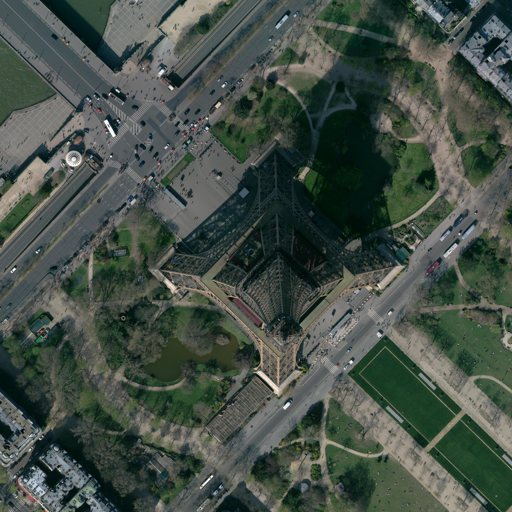

In [48]:
baseurl = 'https://wxs.ign.fr/choisirgeoportail/geoportail/wmts?REQUEST=GetTile&SERVICE=WMTS&VERSION=1.0.0&STYLE=normal&TILEMATRIXSET=PM&FORMAT=image/jpeg&LAYER=ORTHOIMAGERY.ORTHOPHOTOS&TILEMATRIX={z}&TILEROW={y}&TILECOL={x}'
avg = AerialView(zoom=20, baseurl=baseurl)

altitude = 300
bearing = 0 # world map, not local coordinates
fov = 60
lat, lon = 48.858327718853104, 2.294309636169546
img = avg.getAerialImage(lat, lon, bearing, altitude, fov, output_size=(512,512))
img.show()

In [16]:
!pip install -q quad_sim_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import math
from time import sleep
import numpy as np
from aerialviewgenerator.uavphysics import UAVPhysics

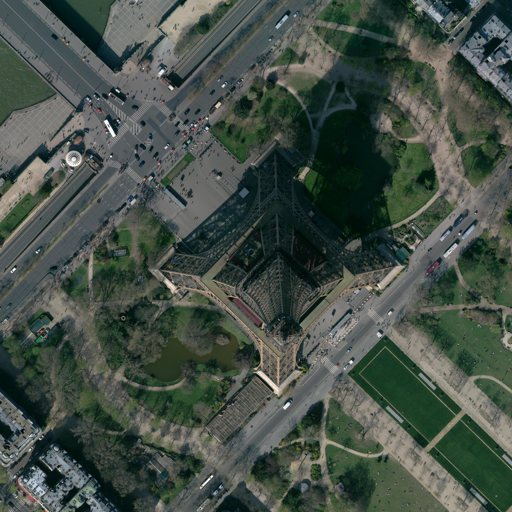

In [49]:
# initialize (x=y=0 for the initial state)
output_img_size = (512,512)
z0 = 300
bearing0 = 0 # world map, not local coordinates
fov = 60 # approximated camera fov
lat0, lon0 = lat, lon

currLatLon = [lat0, lon0]

uav = UAVPhysics(z0=z0, ctrlParams={"Px":1, "Py":1, "Pz":1, "uMax" : 15.0, "vMax" : 15.0, "wMax" : 5.0})
img = avg.getAerialImage(currLatLon[0], currLatLon[1], bearing0, z0, fov, output_size=output_img_size)
img

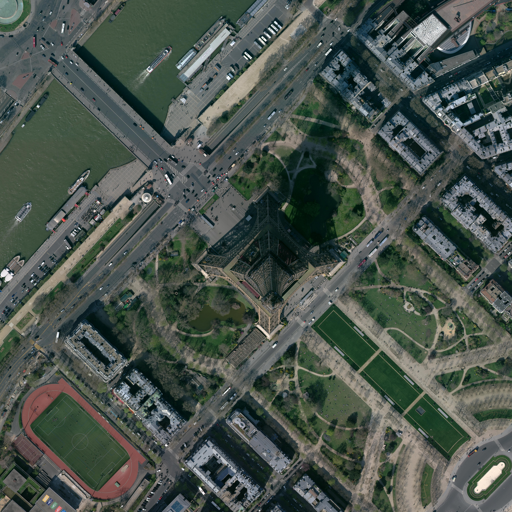

In [50]:
# initialize (x=y=0 for the initial state)
output_img_size = (512,512)
z0 = 500
bearing0 = 0 # world map, not local coordinates
fov = 60 # approximated camera fov
lat0, lon0 = lat, lon

currPos = np.asarray([0,0,z0])
currLatLon = [lat0, lon0]

uav = UAVPhysics(z0=z0, ctrlParams={"Px":1, "Py":1, "Pz":1, "uMax" : 15.0, "vMax" : 15.0, "wMax" : 5.0})

img1 = avg.getAerialImage(currLatLon[0], currLatLon[1], bearing0, z0, fov, output_size=output_img_size)

img1

In [51]:
desPos = [500, -500, 50]  # x and y are relative to the initial position (map coordinates)
dt = 1 # delta t
imgs = []

In [52]:
#
# It will simulate dt for each iteration
#

for i in range(100):
  nextPos = np.asarray(uav.update(desPos, [0]*3, dt))
  diffPos = nextPos - currPos
  currPos = nextPos
  bearing = math.degrees(math.atan2(-diffPos[1],diffPos[0]))+90
  distance = np.linalg.norm(diffPos[:2]) # relative distance

  lat, lon = avg.getPointAtDistance(currLatLon[0], currLatLon[1], distance, bearing)
  currLatLon = [lat, lon]

  # It will rotate the image instantaneously according to the bearing
  # change from bearing to bearing0 to keep it fixed according to the initial one
  img2 = avg.getAerialImage(currLatLon[0], currLatLon[1], bearing, currPos[2], fov, output_size=output_img_size)
  print(f"Current bearing: {bearing}")
  print(f"Current pos: {uav.quad.pos}")
  print(f"Current vel: {uav.quad.vel}")
  print(f"Current acc: {uav.quad.vel_dot}")
  imgs.append(img2)
  sleep(0.1)

Current bearing: 135.26207767408266
Current pos: [  0.7831109   -0.79030796 496.89317277]
Current vel: [ 2.50287758 -2.51048591 -5.12495709]
Current acc: [ 4.58279655 -4.57731303 -1.50351755]
Current bearing: 135.03131295140892
Current pos: [  5.49005095  -5.50239564 491.51866383]
Current vel: [ 6.59254279 -6.5950103  -5.3442366 ]
Current acc: [ 2.90349053 -2.89970398  0.30353781]
Current bearing: 135.00473471445042
Current pos: [ 13.11378952 -13.12739431 486.3156935 ]
Current vel: [ 8.30894504 -8.30949115 -5.08969103]
Current acc: [ 0.83071051 -0.82993208  0.15858439]
Current bearing: 135.00099628148752
Current pos: [ 21.68834011 -21.7022431  481.27758264]
Current vel: [ 8.73407495 -8.73421971 -5.00789378]
Current acc: [ 0.17397607 -0.17379377  0.02933898]
Current bearing: 135.00027143632516
Current pos: [ 30.47584009 -30.48982634 476.27706836]
Current vel: [ 8.81843812 -8.81848094 -4.9977407 ]
Current acc: [ 0.03274036 -0.03268912  0.00024375]
Current bearing: 135.0000813564011
Curre

In [53]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [56]:
fig, ax = plt.subplots()
ims = []
for i,img in enumerate(imgs[:-1]):
    plt.axis('off')
    img = ax.imshow(img, animated=True)
    txt = ax.text(5, 20, f"Step {i}", fontsize=8, color='white', animated=True)
    ims.append([img, txt])
plt.close()

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat=False)

In [57]:
HTML(ani.to_html5_video())